# 2. Exploratory Data Analysis (EDA) & Data Preparations
## Product Sales Strategy Analysis

The objective of this notebook is to explore patterns and relationships
within the validated product sales data and prepare analysis-ready
datasets.

This phase applies targeted data cleaning, transformation, and feature
engineering steps strictly to support exploratory analysis and
visualization. These steps are informed by findings from the data
validation phase and do not replace it.

## Data Quality & Preparation:

### Import Libraries:

In [1]:
# Libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("default")

### Ingest Dataset(csv):

In [2]:
# Ingest Raw data:

p_sales = pd.read_csv("../data/raw/product_sales.csv")

### Check Dataset:

In [3]:
# Data Validation:

print(p_sales.shape)
print(p_sales.shape)
print(p_sales.columns)
p_sales.info()
p_sales.head()

(15000, 8)
(15000, 8)
Index(['week', 'sales_method', 'customer_id', 'nb_sold', 'revenue',
       'years_as_customer', 'nb_site_visits', 'state'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## Data Hadnling:

#### Check Duplicates (customer_id):

In [4]:
multiple_transactions = p_sales["customer_id"].value_counts().max() > 1
print(multiple_transactions)

False


- No Duplicate customer_id

#### Date Outliers (years_as_customer):

In [5]:
# years in Operations:

2026 - 1984 # its only been 42years since the company went production

42

In [6]:
p_sales[p_sales['years_as_customer']>42]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


- its only been 42years since the company went production
- there are 2 entries that is more than 42years in this dataset
- i suppose we can drop them

In [7]:
# Drop Outliers:

p_sales = p_sales[p_sales['years_as_customer'] <= 42]

# Validate drop
p_sales[p_sales['years_as_customer']>42]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state


- values are within a reasonable range

#### Standardization (Sales method):

In [8]:
# standardize the column sales_method:

p_sales["sales_method"] = (
    p_sales["sales_method"]
    .str.lower()
    .str.strip()
    .replace({
        "email": "Email",
        "call": "Call",
        "email + call": "Email + Call",
        "em + call": "Email + Call"
    })
)

p_sales["sales_method"].value_counts()

sales_method
Email           7465
Call            4961
Email + Call    2572
Name: count, dtype: int64

- Sales method labels were standardized to enable accurate grouping and comparison during exploratory analysis.
- correcting misss spelled sales method categories and reducing 5 categories into 3 

#### Missing Values (Revenue):

In [9]:
# Missing value Indicator:

p_sales["revenue_missing"] = p_sales["revenue"].isna()

In [10]:
# Contingency Table to check variability:

contingency = pd.crosstab(
    p_sales["sales_method"],
    p_sales["revenue_missing"]
)

contingency

revenue_missing,False,True
sales_method,,
Call,4780,181
Email,6921,544
Email + Call,2223,349


In [11]:
# Contingency Table to Check % of missing values per sales method:

contingency_percent = contingency.div(contingency.sum(axis=1), axis=0) * 100
contingency_percent

revenue_missing,False,True
sales_method,,
Call,96.351542,3.648458
Email,92.712659,7.287341
Email + Call,86.430793,13.569207


In [12]:
# Missing Proportion:

total_missing_pct = (p_sales.revenue.isna().sum() / len(p_sales)) * 100
print(f"Overall missing revenue: {total_missing_pct:.2f}%")

Overall missing revenue: 7.16%


In [13]:
chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi2 statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}\n")
print("Expected frequencies:\n", pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))

# # p-value < 0.05 = missingness depends on sales_method (not random)
# p-value ≥ 0.05 = missingness is likely random

Chi2 statistic: 251.12
p-value: 0.0000
Degrees of freedom: 2

Expected frequencies:
 revenue_missing        False       True 
sales_method                            
Call             4605.745033  355.254967
Email            6930.434725  534.565275
Email + Call     2387.820243  184.179757


#### Data Imputation(Revenue):

In [14]:
# Data Imputation:

p_sales['revenue_imputed'] = p_sales['revenue'] # new column based on 'revenue'

# Impute missing revenue with median per sales_method
p_sales['revenue_imputed'] = (
    p_sales.groupby('sales_method')['revenue_imputed'] \
                                     .transform(lambda x: x.fillna(x.median()))) # fills missing values within each group

p_sales[['sales_method', 
         'revenue', 
         'revenue_imputed', 
         'revenue_missing']].head(10)

,sales_method,revenue,revenue_imputed,revenue_missing
0,Email,NaN,95.58,True
1,Email + Call,225.47,225.47,False
2,Call,52.55,52.55,False
3,Email,NaN,95.58,True
4,Email,90.49,90.49,False
5,Call,65.01,65.01,False
6,Email,113.38,113.38,False
7,Email,99.94,99.94,False
8,Email,108.34,108.34,False
9,Call,53.82,53.82,False


#### Data Handling Summary

Sales Method Standardization

The `sales_method` column contained inconsistent labels and some misspellings.  
To ensure **accurate grouping and comparison** during exploratory analysis, the column was standardized

**Outliers in Years as Customer:**

- Some rows had unusually high `years_as_customer` values (63 and 47 years), which are clearly **outliers**.  
- These extreme values were **removed** from the dataset to avoid skewing analysis, ensuring the tenure column reflects a **reasonable range of customer years**.

**Missing Revenue:**

- There are more than 5% missing values in the `revenue` column, so we **cannot simply drop rows** without examining the randomness of the missing data.
- If the missing values are **Missing Completely At Random (MCAR)** or **Missing At Random (MAR)**, dropping them may be less problematic.  
- However, if they are **Missing Not At Random (MNAR)**, dropping them could introduce bias.

**Chi-Square Test for Missingness:**

- **Chi2 statistic:** 251.20  
- **p-value:** 0.0000  
- **Degrees of freedom:** 2  

**Interpretation:**  
The **p-value < 0.05** indicates that missing revenue is **not independent** of `sales_method`.  
Some sales methods have a higher proportion of missing revenue (Email + Call: 13.57%).  
Thus, **dropping missing rows could introduce bias**.

**Revenue Distribution Note:**

- The `revenue` column shows a **slightly positive skew** (mean: 93.93, median: 89.50).  
- Because of this skew, **median is preferred over mean** for summarizing central tendency or imputing missing values.  
- **Imputation:** Missing revenue values were filled with the **median per `sales_method`** into a new column `revenue_imputed`.


**Final Handling Summary:**

- `revenue_missing` flag retained to track which rows were imputed.  
- `revenue_imputed` contains the imputed revenue values.  
- Outlier rows in `years_as_customer` removed.  

This prepares the dataset for further analysis, including **categorical revenue analysis and relationships with sales methods**.


## Univariate Analysis:

#### Revenue Distribution:

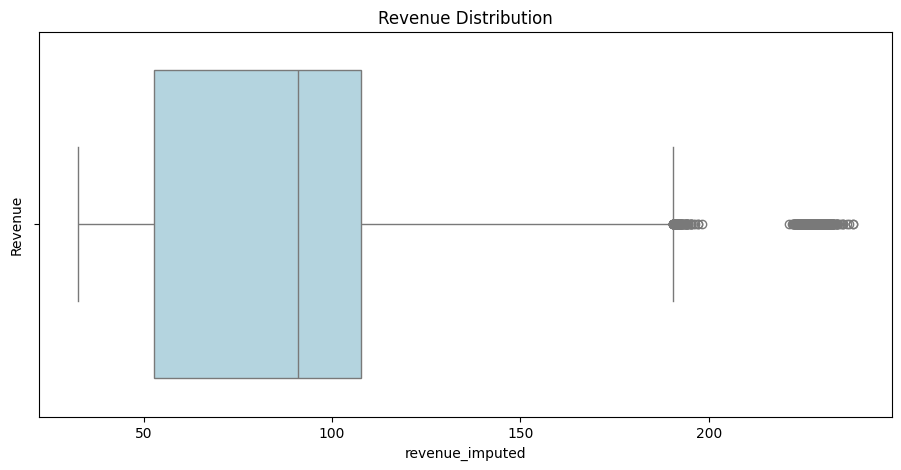

In [36]:
# Revenue:

plt.figure(figsize=(11, 5))
sns.boxplot(data = p_sales, 
            x = 'revenue_imputed',
            color='lightblue'
)
plt.ylabel('Revenue')
plt.title('Revenue Distribution')
plt.show()

In [16]:
p_sales['revenue_imputed'].describe()

count    14998.000000
mean        95.568619
std         47.987200
min         32.540000
25%         52.650000
50%         90.950000
75%        107.750000
max        238.320000
Name: revenue_imputed, dtype: float64

In [17]:
mean_revenue = p_sales['revenue_imputed'].mean()
median_revenue = p_sales['revenue_imputed'].median()

mean_revenue, median_revenue

(np.float64(95.56861914921988), np.float64(90.95))

## Feature Engr:

In [18]:
# Revenue Categories

p_sales.loc[:, 'revenue_category'] = pd.qcut( # to cut em up
    p_sales['revenue_imputed'],
    q=3,  # cut them to 3 & put em to bins
    labels=['Low', 'Medium', 'High'] # the bins
)

p_sales['revenue_category'].value_counts()

revenue_category
High      5000
Low       4999
Medium    4999
Name: count, dtype: int64

- we cluster revenue level per category based on sales value they have

## Multi Variate Analysis:

### Revenue x SAles method:

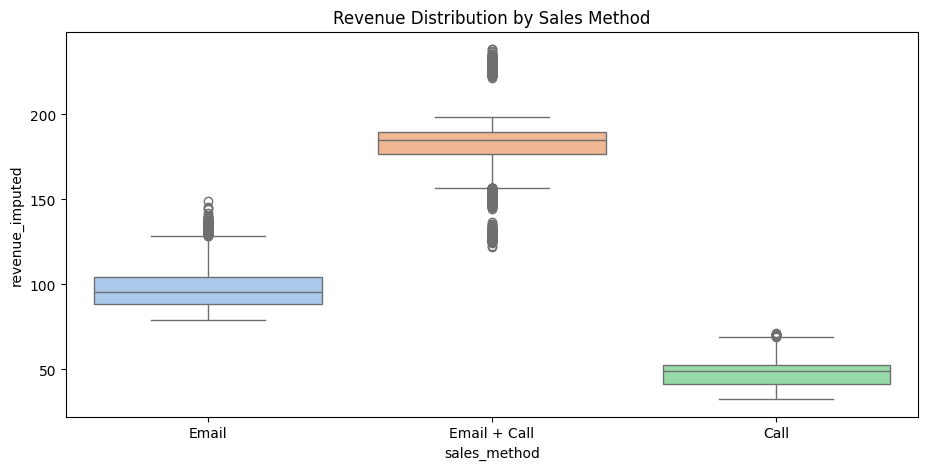

In [33]:
# Revenue x SAles method:

plt.figure(figsize=(11, 5))
sns.boxplot(data=p_sales, 
            x='sales_method', 
            y='revenue_imputed',
            hue='sales_method',
            palette='pastel'
)
plt.title('Revenue Distribution by Sales Method')
plt.show()

In [20]:
p_sales.groupby('sales_method')['revenue_imputed'].describe()

,count,mean,std,min,25%,50%,75%,max
sales_method,,,,,,,,
Call,4961.0,47.649883,8.456520,32.54,41.6300,49.05,52.590,71.36
Email,7465.0,97.014887,10.802488,78.83,88.3900,95.58,104.460,148.97
Email + Call,2572.0,183.798970,27.040536,122.11,176.4375,184.74,189.535,238.32


- **Call** generates the lowest revenue per customer, with values tightly
  clustered at the lower end of the revenue range.
- **Email** produces moderate revenue outcomes, with customers primarily
  concentrated in the medium-to-high revenue range.
- **Email + Call** consistently generates the highest revenue per customer,
  with a significantly higher median and upper quartile than other methods.


### Proportion bar:

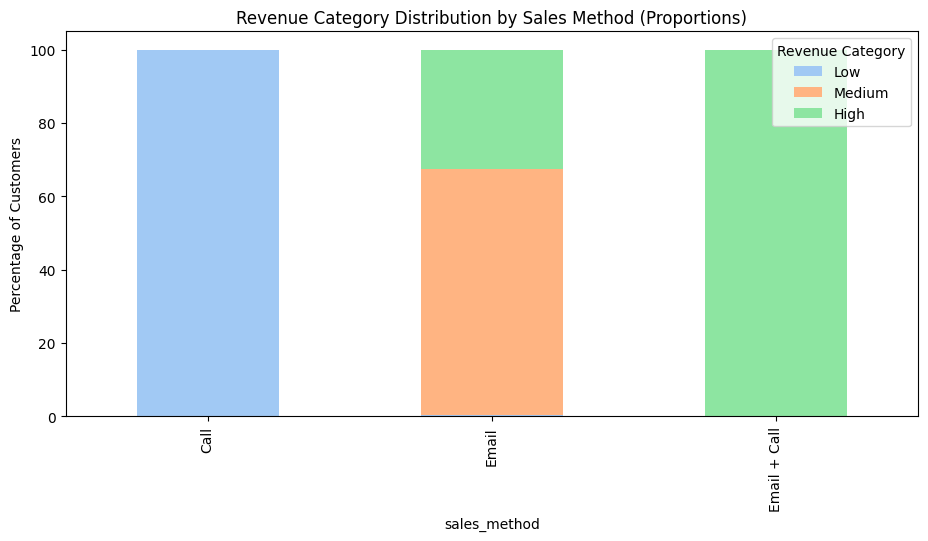

In [31]:
# Proportion table:

prop_table = pd.crosstab(
    p_sales['sales_method'],
    p_sales['revenue_category'],
    normalize='index'
) * 100

# I like pastel colors
colors = sns.color_palette('pastel', n_colors=len(prop_table.columns))

# Plot stacked bar chart
prop_table.plot(kind='bar', 
                stacked=True, 
                figsize=(11,5),
                color=colors # ill add it here xP
)
plt.ylabel('Percentage of Customers')
plt.title('Revenue Category Distribution by Sales Method (Proportions)')
plt.legend(title='Revenue Category')
plt.show()

### Analyze relationships between sales_method and revenue:

### Chi-Square:

In [22]:
# Contingency table to check relationship:

contingency = pd.crosstab(
    p_sales['sales_method'],
    p_sales['revenue_category']
)
print(contingency)

# Chi test
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi2 statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Expected frequencies:")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))

# p-value < 0.05 = revenue distri depends on sales method
# p-value ≥ 0.05 = revenue distri is independent of sales method

revenue_category   Low  Medium  High
sales_method                        
Call              4961       0     0
Email               38    4999  2428
Email + Call         0       0  2572
Chi2 statistic: 20013.89
p-value: 0.0000
Degrees of freedom: 4
Expected frequencies:
revenue_category          Low       Medium         High
sales_method                                           
Call              1653.556408  1653.556408  1653.887185
Email             2488.167422  2488.167422  2488.665155
Email + Call       857.276170   857.276170   857.447660


certain sales methods clearly correspond to different revenue levels.
- Call: almost all customers fall into the Low revenue category.
- Email: most customers are Medium or High revenue.
- Email + Call: all customers are in the High revenue category
  
Chi2 statistic: 20013.89

p-value: 0.0000
Degrees of freedom: 4

- The p-value < 0.05 indicates a significant relationship between sales_method and revenue_category, this also indicates that revenue category distribution is significantly dependent on the sales method
- meaning: distribution of revenue categories depends on the sales method used
- Certain sales methods clearly correspond to different revenue levels: 
    - Call tends to generate low revenue customers.
    - Email reaches mostly medium and high revenue customers.
    - Email + Call is associated with high revenue customers only.
- This suggests the combined method (Email + Call) is highly effective for generating high revenue customers
- highlighted in green indicates effectiveness of combined sales/call method for generating high revenue in contrastto both call & email in separate avenues
  

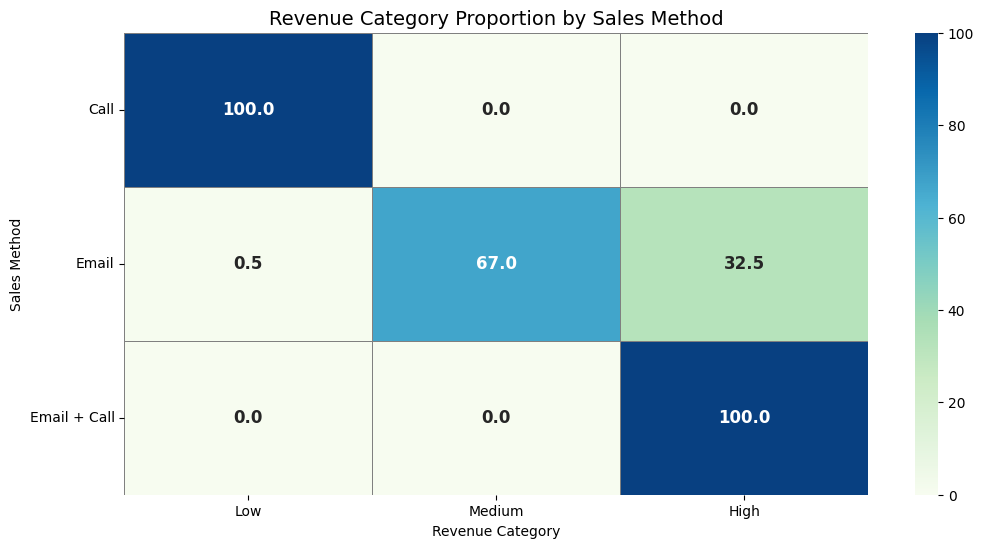

In [45]:
# Heatmap

plt.figure(figsize=(12, 6))
# sns.heatmap(
#     prop_table, 
#     annot=True, 
#     fmt=".1f", 
#     cmap="Blues",
#     cbar=True,
#     vmin=0,
#     vmax=100,
#     annot_kws={"size": 12, "weight": "bold"}
# )

sns.heatmap(
    prop_table, 
    annot=True, 
    fmt=".1f", 
    cmap="GnBu", 
    cbar=True, 
    vmin=0, vmax=100,
    annot_kws={"size":12, "weight":"bold"},
    linewidths=.5, linecolor='gray',
    # palette='pastel'
    
)

plt.title('Revenue Category Proportion by Sales Method', fontsize=14)
plt.ylabel('Sales Method')
plt.xlabel('Revenue Category')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10, rotation=0)
plt.show()

- Call customers are almost entirely Low revenue
- Email customers are split between Medium and High
- Email + Call customers are 100% High revenue
- Differences are not driven by sample size, they reflect true distributional differences

## Save Datasset:

In [24]:
# save point:

# Save to processed directory
p_sales.to_csv('../data/processed/p_sales_cleaned.csv', index=False)

## Exploratory Data Analysis (EDA) Summary

This notebook focuses on understanding the structure, quality, and behavior of the dataset through exploratory analysis.

Key activities included:
- Data validation
- Distribution analysis
- Missing value assessment
- Exploratory visualizations to identify patterns, anomalies, and relationships

The insights generated here informed feature engineering decisions and guided the focused analyses presented in the subsequent Data Analysis notebook.

While some visuals appear in both notebooks, their purposes differ:
- **EDA:** supports exploration and understanding
- **DA notebook:** presents refined, decision-focused insights

This study reflects the business question: 
> *Which sales method is most effective at generating revenue for the new product line?*  

Only the most relevant metrics were selected to answer this question. Features such as **sales per week** and **site visits** were excluded for the following reasons:

### 1. Sales by Week
- Relevant only if there is a date, day, or week variable and all sales methods are active across the same time window
- Only included if seasonality or launch effects are significant
- If timing does not change interpretation, it adds no value

**Conclusion:** Sales volume and revenue trends over time were reviewed to ensure no temporal bias influenced the comparison between sales methods.

### 2. Site Visits
- Could be considered if the feature includes variability in visits, sessions, or touchpoints
- Must be clearly linked to sales methods (e.g., Email, Call, Email + Call)
- Only relevant if online sales are conducted and tracked reliably
- In this dataset, site visits do **not** equal conversions or revenue and can introduce confounding variability

**Conclusion:** Including site visits in this study would:
- Complicate interpretation  
- Require funnel modeling (not possible with current data)  
- Dilute the clean, focused narrative




> my markdown notes are improving : )